## Skin Cancer Classification
Task is to build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Steps
#### - Data Reading/Data Understanding
#### - Dataset Preparation
#### - Dataset visualisation
#### - Model Building & training
#### - Data augmentation
#### - Model Building & training on the augmented data
#### - Handling class imbalances
#### - Model Building & training on the rectified class imbalance data
#### - Conclusion

In [183]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

### Data Reading/Data Understanding

In [184]:
# from google.colab import drive
# drive.mount('/content/drive')

In [185]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("SkinImages/Train")
data_dir_test = pathlib.Path("SkinImages/Test")

In [186]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Dataset Preparation
##### Using batch size of 32 and resizing images to 180x180.

In [187]:
batch_size = 32
img_height = 180
img_width = 180

##### Using 80% of the images for training, and 20% for validation.

In [188]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [189]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [412]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print("Number of classes: ", num_classes)

AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [191]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Dataset visualisation

In [192]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(5):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# ### your code goes here, you can use training or validation data to visualize

### Model Building & training

Using `layers.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. It is good to standardize values to be in the `[0, 1]`

In [193]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [194]:
### Your code goes here
#num_classes = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(512, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes, activation='softmax')
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

In [195]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [196]:
# View the summary of all layers
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_24 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

##### Train the model

In [197]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 496ms/step - accuracy: 0.2401 - loss: 3.0521 - val_accuracy: 0.3445 - val_loss: 1.8291
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step - accuracy: 0.3924 - loss: 1.7251 - val_accuracy: 0.4407 - val_loss: 1.5781
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.4679 - loss: 1.5064 - val_accuracy: 0.5101 - val_loss: 1.4750
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 384ms/step - accuracy: 0.5106 - loss: 1.4422 - val_accuracy: 0.4922 - val_loss: 1.4342
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.5513 - loss: 1.2704 - val_accuracy: 0.5213 - val_loss: 1.3911
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.5876 - loss: 1.1820 - val_accuracy: 0.5302 - val_loss: 1.3995
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.6122 - loss: 1.1086 - val_accuracy: 0.5145 - val_loss: 1.5407
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.6408 - loss: 0.9883 - val_accu

##### Visualizing the results

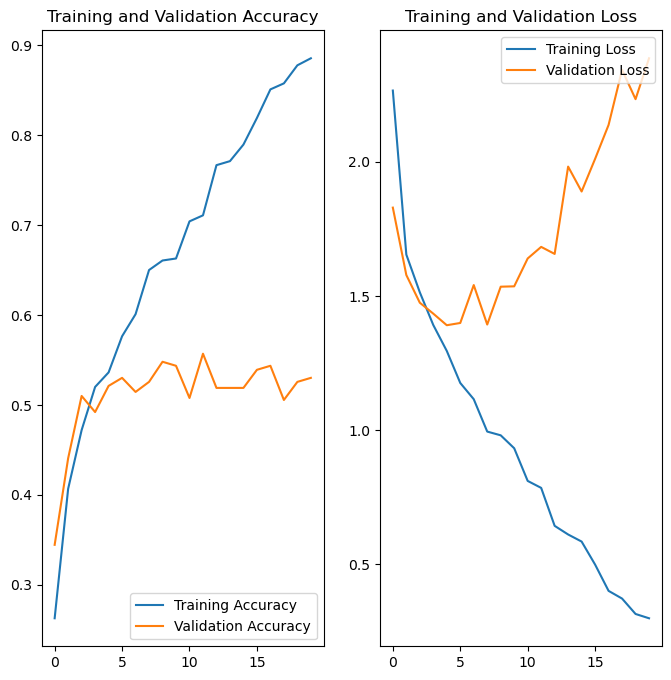

In [198]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### From plots it is clear that model is overfit so we will use data augmentation and see if we can improve the model. We will also add dropout layer to prevent overfitting.

### Data augmentation


In [199]:
# Choosing the following strategy for data augmentation 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                   img_width,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
  ]
)

In [200]:
# visualizing how augmentation strategy works for one instance of training image.
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

### Model Building & training on the augmented data

In [201]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [202]:
### Your code goes here
#num_classes = 9

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),.
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [204]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [205]:
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_35 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_25 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Train the model

In [206]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 421ms/step - accuracy: 0.1798 - loss: 2.8460 - val_accuracy: 0.1566 - val_loss: 2.0537
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.2587 - loss: 1.9876 - val_accuracy: 0.3400 - val_loss: 1.8541
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.3434 - loss: 1.7891 - val_accuracy: 0.3736 - val_loss: 1.6634
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step - accuracy: 0.3275 - loss: 1.7291 - val_accuracy: 0.3870 - val_loss: 1.6465
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 417ms/step - accuracy: 0.3672 - loss: 1.6995 - val_accuracy: 0.3691 - val_loss: 1.6588
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.3577 - loss: 1.6793 - val_accuracy: 0.3199 - val_loss: 1.7049
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.3819 - loss: 1.6748 - val_accuracy: 0.4183 - val_loss: 1.5912
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 421ms/step - accuracy: 0.3926 - loss: 1.6340 - val_accu

##### Visualizing the results

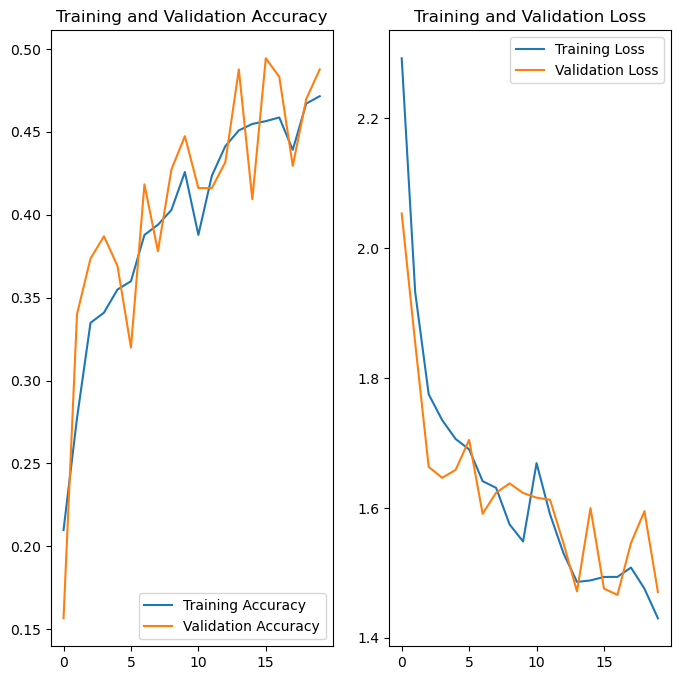

In [207]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Both the train and validation accuracies are low indicating underfitting. May be the model is unable to learn basic patterns in data due to limited train data.

##### Let us find out distribution of classes in the dataset to know any class imbalance.

### Class distribution

##### Visualizing distribution of classes in the training dataset.

In [408]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

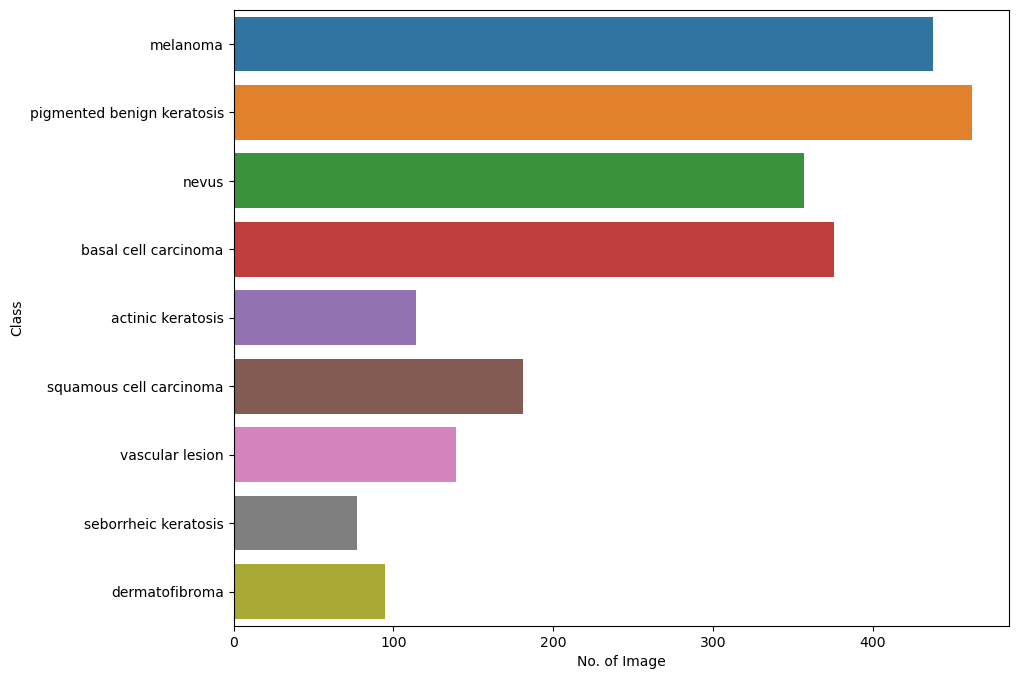

In [409]:
#Visualize the Number of images in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

##### `seborrheic keratosis` class has the least number of samples.
##### `pigmented benign keratosis`,`melanoma`,`basal cell carcinoma` and `nevus` classes dominate the data in terms of proportionate number of samples.

##### We can see there is a class imbalance. Some classes have very small number of train samples. To solve this we will use package `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

### Handling class imbalances

In [210]:
#install Augmentor
!pip install Augmentor

In [411]:
path_to_training_dataset="SkinImages/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to SkinImages/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 376 image(s) found.
Output directory set to SkinImages/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x34CB7B890>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to SkinImages/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 438 image(s) found.
Output directory set to SkinImages/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x318C78990>: 100%|█


Initialised with 357 image(s) found.
Output directory set to SkinImages/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0


Initialised with 462 image(s) found.
Output directory set to SkinImages/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 77 image(s) found.
Output directory set to SkinImages/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 181 image(s) found.
Output directory set to SkinImages/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 139 image(s) found.
Output directory set to SkinImages/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


In [413]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Model Building & training on the rectified class imbalance data 

In [457]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [458]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [459]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [460]:
model = Sequential([
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),  # Rescaling layer
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [461]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [462]:
model.summary()

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_57 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_177 (Conv2D)             │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_177               │ (None, 90, 90, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_178 (Conv2D)             │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_178               │ (None, 45, 45, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_179               │ (None, 22, 22, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_63 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

##### We will increase number of epochs giving the model more time to learn to prevent underfitting.

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
 85/169 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.1680 - loss: 2.1409

In [451]:
acc30 = history.history['accuracy'][-1]
val_acc30 = history.history['val_accuracy'][-1]
print("acc30 = ", acc30)
print("val_acc30 = ", val_acc30)
loss30 = history.history['loss'][-1]
val_loss30 = history.history['val_loss'][-1]
print("loss30 = ", loss30)
print("val_loss30 = ", val_loss30)

acc30 =  0.8877967596054077
val_acc30 =  0.8032665252685547
loss30 =  0.29774656891822815
val_loss30 =  0.8302730917930603


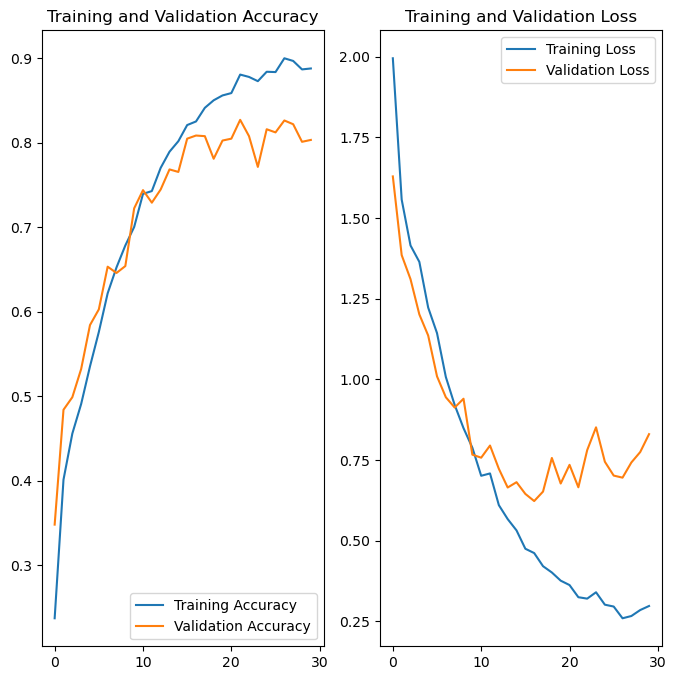

In [452]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss') 

plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion

##### By increasing number of samples to rebalance the dataset the accuracies have increased and we could get rid of underfitting.
##### Data augmentation, class imbalance handling and adding dropout layers greatly improved model performance.

### Model Prediction

In [453]:
from glob import glob
for class_name in class_names:
    Test_image_path = os.path.join(data_dir_test, class_name, '*')
    Test_image = glob(Test_image_path)
    Test_image = load_img(Test_image[-1],target_size=(180,180,3))
#     plt.imshow(Test_image)
#     plt.grid(False)

    img = np.expand_dims(Test_image,axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    pred_class = class_names[pred]
    print("Actual Class ["+ class_name +'] \n'+ "Predictive Class [" + pred_class + ']')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Actual Class [actinic keratosis] 
Predictive Class [nevus]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Actual Class [basal cell carcinoma] 
Predictive Class [basal cell carcinoma]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Actual Class [dermatofibroma] 
Predictive Class [pigmented benign keratosis]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Actual Class [melanoma] 
Predictive Class [melanoma]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Actual Class [nevus] 
Predictive Class [nevus]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Actual Class [pigmented benign keratosis] 
Predictive Class [basal cell carcinoma]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Actual Class [seborrheic keratosis] 
Predictive Class [melanoma]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Actual Class [squamous cell carcinoma] 
Predictive Class [actinic keratosis]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Actual Class [vascular lesion] 
Predictive Class [basal cell carcinoma]
